In [2]:
import pandas as pd
from simplec import Simulation

from simplec_examples.models.building_model import BuildingModel
from simplec_examples.models.heat_pump import HeatPump, HeatPumpEventBased
from simplec_examples.models.hyst_controller import HystController
from simplec_examples.models.weather_model import LocalWeather

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# %matplotlib ipympl

In [3]:
sim_event = Simulation()

building   = BuildingModel('building')
heatpump   = HeatPumpEventBased('heatpump')
controller = HystController('controller', hyst=1.2)
weather    = LocalWeather('weather')

sim_event.add_model(building,   watch_values=['T_room1', 'T_room2', 'T_amb', 'apparent_zenith', 'dhi', 'ghi']  )
sim_event.add_model(heatpump,   watch_values=['state', 'P_el', 'dot_Q_hp'])
sim_event.add_model(controller, watch_values=['T_is', 'state'])
sim_event.add_model(weather,    watch_values=['apparent_zenith', 'dhi', 'ghi'])

sim_event.connect(weather, building, ('T_air', 'T_amb'), 'apparent_zenith', 'azimuth', 'dni', 'dhi', 'ghi')
sim_event.connect(weather, heatpump, ('T_air', 'T_source'))
sim_event.connect(heatpump, building, ('dot_Q_hp', 'dot_Q_heat'))
sim_event.connect(controller, heatpump, ('state', 'state'), triggers=['state'])

sim_event.connect(building, heatpump, ('T_room1', 'T_sink'), time_shifted=True, init_values={'T_room1': 21})
sim_event.connect(building, controller, ('T_room1', 'T_is'), time_shifted=True, init_values={'T_room1': 21})

times = pd.date_range('2021-01-01 00:00:00', '2021-01-03 00:00:00', freq='1min', tz='UTC+01:00')

sim_event.run(times)

df_event = sim_event.df

for col in df_event.columns:
    # Attempt to convert the column to numeric
    df_event[col] = pd.to_numeric(df_event[col], errors='ignore')
df_event =df_event.ffill()

Progress: 100%|██████████| 2881/2881 [00:10<00:00, 283.12Steps/s]


In [5]:
sim_discrete = Simulation()

building   = BuildingModel('building')
heatpump   = HeatPump('heatpump')
controller = HystController('controller', hyst=1.2)
weather    = LocalWeather('weather')

sim_discrete.add_model(building,   watch_values=['T_room1', 'T_room2', 'T_amb', 'apparent_zenith', 'dhi', 'ghi']  )
sim_discrete.add_model(heatpump,   watch_values=['state', 'P_el', 'dot_Q_hp'])
sim_discrete.add_model(controller, watch_values=['T_is', 'state'])
sim_discrete.add_model(weather,    watch_values=['apparent_zenith', 'dhi', 'ghi'])

sim_discrete.connect(weather, building, ('T_air', 'T_amb'), 'apparent_zenith', 'azimuth', 'dni', 'dhi', 'ghi')
sim_discrete.connect(weather, heatpump, ('T_air', 'T_source'))
sim_discrete.connect(heatpump, building, ('dot_Q_hp', 'dot_Q_heat'))
sim_discrete.connect(controller, heatpump, ('state', 'state'))

sim_discrete.connect(building, heatpump, ('T_room1', 'T_sink'), time_shifted=True, init_values={'T_room1': 21})
sim_discrete.connect(building, controller, ('T_room1', 'T_is'), time_shifted=True, init_values={'T_room1': 21})

times = pd.date_range('2021-01-01 00:00:00', '2021-01-03 00:00:00', freq='1min', tz='UTC+01:00')

sim_discrete.run(times)

df_discrete = sim_discrete.df

for col in df_discrete.columns:
    # Attempt to convert the column to numeric
    df_discrete[col] = pd.to_numeric(df_discrete[col], errors='ignore')
df_discrete = df_discrete.ffill()


Progress: 100%|██████████| 2881/2881 [00:12<00:00, 234.11Steps/s]


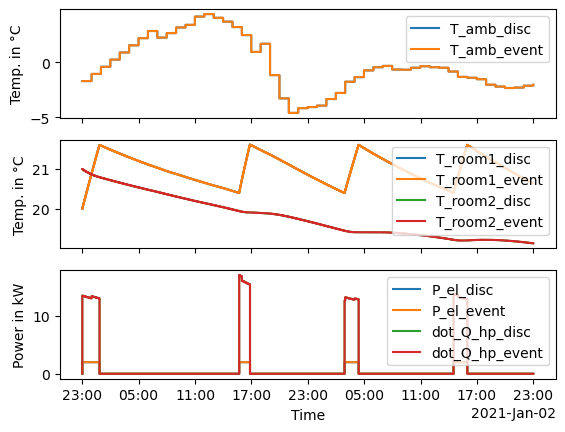

In [6]:
dtindex = df_discrete.index

fig, ax = plt.subplots(3, sharex=True)
ax[0].plot(dtindex, df_discrete.loc[:, ('building', 'inputs', 'T_amb')], label='T_amb_disc', drawstyle='steps')
ax[0].plot(dtindex, df_event.loc[:, ('building', 'inputs', 'T_amb')], label='T_amb_event', drawstyle='steps')
ax[0].legend()
ax[0].set_ylabel('Temp. in °C')

# Roomtemperatures
ax[1].plot(dtindex, df_discrete.loc[:, ('building', 'outputs', 'T_room1')], label='T_room1_disc', drawstyle='steps')
ax[1].plot(dtindex, df_event.loc[:, ('building', 'outputs', 'T_room1')], label='T_room1_event', drawstyle='steps')

ax[1].plot(dtindex, df_discrete.loc[:, ('building', 'outputs', 'T_room2')], label='T_room2_disc', drawstyle='steps')
ax[1].plot(dtindex, df_event.loc[:, ('building', 'outputs', 'T_room2')], label='T_room2_event', drawstyle='steps')
ax[1].legend()
ax[1].set_ylabel('Temp. in °C')

ax[2].plot(dtindex, df_discrete.loc[:, ('heatpump', 'outputs', 'P_el')]/1000, label='P_el_disc', drawstyle='steps')
ax[2].plot(dtindex, df_event.loc[:, ('heatpump', 'outputs', 'P_el')]/1000, label='P_el_event', drawstyle='steps')

ax[2].plot(dtindex, df_discrete.loc[:, ('heatpump', 'outputs', 'dot_Q_hp')]/1000, label='dot_Q_hp_disc', drawstyle='steps')
ax[2].plot(dtindex, df_event.loc[:, ('heatpump', 'outputs', 'dot_Q_hp')]/1000, label='dot_Q_hp_event', drawstyle='steps')
ax[2].legend()
ax[2].set_ylabel('Power in kW')

ax[-1].set_xlabel('Time')
ax[-1].xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax[-1].xaxis.get_major_locator(),))

In [7]:
df_event.compare(df_discrete)

Empty DataFrame
Columns: []
Index: []